## DataSet

This dataset from [Kaggle](https://www.kaggle.com/rsrishav/youtube-trending-video-dataset) includes data on daily trending YouTube videos for three years(including current year 2022). Data is included for the IN, US, GB, DE, CA, FR, RU, BR, MX, KR, and JP regions (India, USA, Great Britain, Germany, Canada, France, Russia, Brazil, Mexico, South Korea, and, Japan respectively), with up to 200 listed trending videos per day.

Each region’s data is in a separate file. Data includes the video id, video title, channel title, publish time, trending date, tags, views counts, likes and dislikes, description, and comment count.

The data also includes a category_id field, which varies between regions. To retrieve the categories for a specific video, it must be located in the associated JSON. A JSON file is included for each of the 11 regions in the dataset.

From the large dataset in the Kaggle, we used the dataset for the US region and the US category_id field data.

##<u>Import Packages</u>

In [ ]:
import sys
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import os
import pandas as pd
import io
import numpy as np 
import json
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
# %matplotlib inline
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
plt.ion()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import Counter
import wordcloud



##<u>Loading the dataset</u>

<b>Load the datasets of youTube trending videos in US as you see below displayed by its first few rows.

In [ ]:
# loading data
pd.set_option('display.max_rows', None)

# Read in the data file for US
df = pd.read_csv('./US_youtube_trending_data.csv')
df.head()


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


Preliminary insights - Looking at the dataset information we see that are 113,991 entries in the dataset fully completed indicated by count of non-null. However, we can see there are some null entries for the description column. Also the fields "publishedAt" and "trending_date" are of object types. Taking a deeper look at the dataset, we also find many non-english terms in the tags and title columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113991 entries, 0 to 113990
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           113991 non-null  object
 1   title              113991 non-null  object
 2   publishedAt        113991 non-null  object
 3   channelId          113991 non-null  object
 4   channelTitle       113991 non-null  object
 5   categoryId         113991 non-null  int64 
 6   trending_date      113991 non-null  object
 7   tags               113991 non-null  object
 8   view_count         113991 non-null  int64 
 9   likes              113991 non-null  int64 
 10  dislikes           113991 non-null  int64 
 11  comment_count      113991 non-null  int64 
 12  thumbnail_link     113991 non-null  object
 13  comments_disabled  113991 non-null  bool  
 14  ratings_disabled   113991 non-null  bool  
 15  description        111170 non-null  object
dtypes: bool(2), int64(5)

##<u>Methods and Results</u>

We are first going to clean the dataset changing data types and remove null values and making adjustment to text in the data. After that we would deep dive into Exploratory Data Analysis using various plots to visually see and analyse the data. Look at the time scale of trending video through the years, various user features to make youtube video popular and relationship between these feaatures,categories of the popular video.

1. [Data Cleaning and Preprocessing](#scrollTo=Data_Cleaning_and_Preprocessing)
2. [Exploratory Data Analysis ](#scrollTo=Exploratory_Data_Anaylsis)
3. [Machine Learning](#scrollTo=Machine_Learning)


##<u> Data Cleaning and Preprocessing</u>



Perform preprocessing like dropping the NA values, duplicates, non-insightful columns:<br>
Change the "trending_date" and "publishedAt" fields to datetime objects<br>
Next we will separate the publish date and publish time from the "publishedAt" column and add them to separate columns "publish_date" and "publish_time" respectively.<br>
<br>
There are duplicates in the dataset by video_id since a video can be trending multiple times. We have removed the duplicates and kept only the recent trending entry for any video.<br>
Also we have reset the index after removing duplicates and set the index as video_id. The final dataset will be sorted by trending_date values.

In [ ]:
#Dropping non-insightful columns

df.drop(['thumbnail_link'], axis=1, inplace=True)

#changing object to datetime types
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%Y-%m-%dT%H:%M:%S.%f')
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%S.%f')

df = df.dropna(how='any',inplace=False, axis = 0)

# separating publish date and time fields
df.insert(2, 'publish_date', df['publishedAt'].dt.date)
df.insert(3, 'publish_time', df['publishedAt'].dt.time)
df['publish_date'] = pd.to_datetime(df['publish_date'])

df['trending_date'] = pd.to_datetime(df['trending_date'].dt.date)

df.drop(['publishedAt'], axis=1, inplace=True)

#reset index and drop duplicates
df = df.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='first').set_index('video_id')
df[['trending_date','publish_date','publish_time']].head()

,trending_date,publish_date,publish_time
video_id,,,
3C66w5Z0ixs,2020-08-12,2020-08-11,19:20:14
6f-jjV5LJoE,2020-08-12,2020-08-09,15:00:01
QsUfsZzxi9c,2020-08-12,2020-08-06,17:00:23
THQH9QJKrIE,2020-08-12,2020-08-08,21:15:00
xCkpA4_H1x4,2020-08-12,2020-08-08,14:30:05


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20032 entries, 3C66w5Z0ixs to QWaaJspvl3o
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              20032 non-null  int64         
 1   title              20032 non-null  object        
 2   publish_date       20032 non-null  datetime64[ns]
 3   publish_time       20032 non-null  object        
 4   channelId          20032 non-null  object        
 5   channelTitle       20032 non-null  object        
 6   categoryId         20032 non-null  int64         
 7   trending_date      20032 non-null  datetime64[ns]
 8   tags               20032 non-null  object        
 9   view_count         20032 non-null  int64         
 10  likes              20032 non-null  int64         
 11  dislikes           20032 non-null  int64         
 12  comment_count      20032 non-null  int64         
 13  comments_disabled  20032 non-null  bool          


The dataset consists of "category id" field for which the corresponding category label is given in a separate json file. We will create a new field "category" for the category labels and drop the category_id column.

In [ ]:
df['categoryId'] = df['categoryId'].astype(str)
# df_full['categoryId'] = df['categoryId'].astype(str)

category_id = {}

with open('./US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

df.insert(4, 'category', df['categoryId'].map(category_id))
# df_full.insert(4, 'category', df_full['categoryId'].map(category_id))
category_list = df['category'].unique()
category_list

array(['People & Blogs', 'Autos & Vehicles', 'Gaming', 'News & Politics',
       'Entertainment', 'Sports', 'Film & Animation', 'Education',
       'Music', 'Howto & Style', 'Comedy', 'Pets & Animals',
       'Science & Technology', 'Travel & Events', 'Nonprofits & Activism'],
      dtype=object)

In [ ]:
df.drop(['categoryId'], axis=1, inplace=True)

In [ ]:
print('Shape of US File: '+ str(df.shape))

Shape of US File: (20032, 16)


 We create new columns "c_title" and "c_tags" with only english words and drop the original columns.

In [ ]:
def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [ ]:
def removeNonEnglishWords(text):
    filteredText = []
    for word in text.split():
        if isEnglish(word):
            filteredText.append(word)
    
    return " ".join(filteredText)

In [ ]:
df['isEnglish'] = df.title.apply(lambda s: isEnglish(s))
df[df.isEnglish==False].title.count()

2645

In [ ]:
# Removing non-english words in the title
df['c_title']= df.title.apply(removeNonEnglishWords)

In [ ]:
df.drop(columns=['isEnglish','title'],axis=1,inplace=True)

In [ ]:
df['isEnglish'] = df.tags.apply(lambda s: isEnglish(s))
# Removing non-english words in tags
df['c_tags']= df.tags.apply(removeNonEnglishWords)
df.drop(columns=['isEnglish','tags'],axis=1,inplace=True)

In [ ]:
df.dtypes

index                         int64
publish_date         datetime64[ns]
publish_time                 object
category                     object
channelId                    object
channelTitle                 object
trending_date        datetime64[ns]
view_count                    int64
likes                         int64
dislikes                      int64
comment_count                 int64
comments_disabled              bool
ratings_disabled               bool
description                  object
c_title                      object
c_tags                       object
dtype: object

##<u>Exploratory Data Anaylsis</u>

###Correlation between variables

This dataset provides many options for using correlations to develop regressions for predicting trends with categories and channels. The correlation coefficients in a heatmap such as this one give us an idea of strength(absolute value) and direction (positive/negative) of the relationship. We will especially wish to select strong, positive relationships as the basis of our machine learning operations. Strong negative relationships can be useful but in the case of this research we want to know about increasing trends related to channels, categories and videos.

Correlation is represented as a value between -1 and +1 where +1 denotes the highest positive correlation, -1denotes the highest negative correlation, and 0 denotes that there is no correlation. In the below visualization we have tried finding how related the variables in the dataset are.

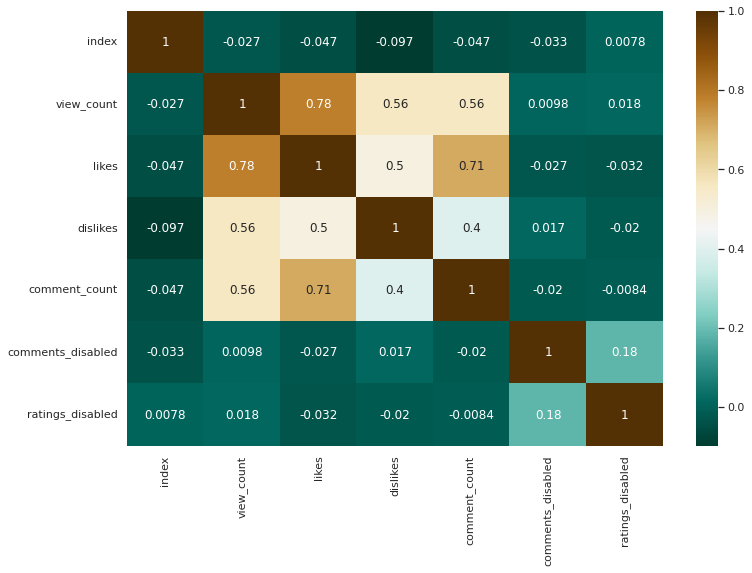

In [ ]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
corr = df.corr()
sns.heatmap(corr,annot=True,cmap='BrBG_r')

As seen in the correlation matrix, there is high positive correlation between views and likes. We will visualize it with the scatter plot.

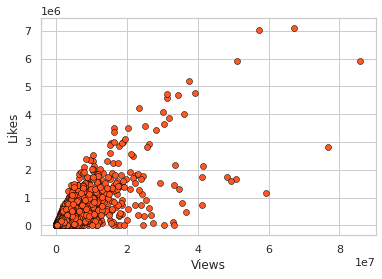

In [ ]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
fig, ax = plt.subplots()
_ = plt.scatter(x=df['view_count'], y=df['likes'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5) 
_ = ax.set(xlabel="Views", ylabel="Likes")

###Trending videos and their publishing time

We will find how many videos were trending per year and calculate the time span between trending date and publish date of video. Also let us find if the trending videos have some relationship with the time of the day it was published.

Number of Trending Youtube Videos by Year, Month, Date in the DataSet:

In [ ]:
tyd = pd.DatetimeIndex(df["trending_date"]).year.value_counts().to_frame().reset_index().rename(columns={"index": "year", "trending_date": "number of videos"})


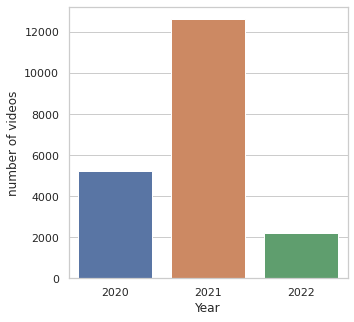

In [ ]:
f, ax = plt.subplots(figsize=(5,5))
_ = sns.barplot(x="year", y="number of videos", data=tyd)
_ = ax.set(xlabel="Year", ylabel="number of videos")

*We normalize the number the video per year, showing the percentage of trending video within each year*

In [ ]:
pd.DatetimeIndex(df["trending_date"]).year.value_counts(normalize=True).round(2).mul(100).astype(str) + '%'

2021    63.0%
2020    26.0%
2022    11.0%
Name: trending_date, dtype: object

As we seen above, there were more number of trending videos in 2021 compare to the other two years

<b>The numbers of days to trending status?

Our dataset contain trending videos, but question is how long does it take to for the videos from the publish date to reach the trending page on average?

We are going to get the number of days it took for the videos to make to the trending status



In [ ]:
labels = []
df['timespan'] = (df['trending_date'] - df['publish_date']).dt.days
df[['timespan','c_title','publish_date', 'trending_date']][:10]

,timespan,c_title,publish_date,trending_date
video_id,,,,
3C66w5Z0ixs,1,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,2020-08-12
6f-jjV5LJoE,3,Road Rage Why Motorcycle Riders Smash Windows,2020-08-09,2020-08-12
QsUfsZzxi9c,6,"Whatever You Build, I'll Pay For!",2020-08-06,2020-08-12
THQH9QJKrIE,4,"Trump signs executive orders on unemployment, ...",2020-08-08,2020-08-12
xCkpA4_H1x4,4,UPDATE: CLAN WARS 2 How does it work? TV Royal...,2020-08-08,2020-08-12
LI1hCQ-6P0Y,4,AN UMBRELLA ACADEMY UNBOXING,2020-08-08,2020-08-12
EukpxRuDUzA,4,Prepping My Apartment for My Boyfriend to Move...,2020-08-08,2020-08-12
TUlFDVUTsKg,5,Highlights | Man City 2-1 Real Madrid | Champi...,2020-08-07,2020-08-12
Idp1xvmLPHo,4,LaBrant Family Baby Boy Name Reveal.,2020-08-08,2020-08-12


A box plot of the timespan for each video_id will help us visualise how long it took the videos to attain the trending status

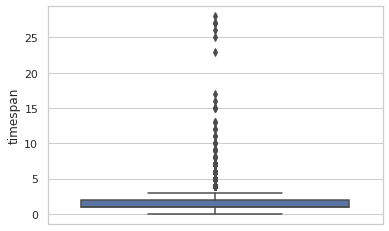

In [ ]:
# Calculating days between publish and trending date
to_trending = df.groupby('video_id').timespan.max()
sns_ax = sns.boxplot(y = to_trending)
plt.show()
_ = sns_ax.set(yscale = "log")

In [ ]:
df.drop(['timespan'], axis=1, inplace=True)


As we can see from the plot above, for most videos it takes between 1 to 3 days for a video to beecome trending. All videos take less than 30 days to reach the trending phase from the intital publish of the video. This can be refered to videos that become viral on internet through shares and subscribed and viewed within this short time span of relevancy.

Here we have is a Time Series Graph that shows the amount of views per month and days as you slide the rangeslider on bottom of the graph.

In [ ]:
labels = {'view_count': 'View Count (Millions)', 'trending_date': 'Trending Date'}
fig = px.line(df, x='trending_date', y='view_count', title='View Count Time Series for category)', labels=labels)
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title_x=0.5)
fig.show()

Which publishing day and hour had the largest number of trending videos?

In [ ]:
df["publish_day"] = df["publish_date"].dt.day_name()
df["publish_hour"] = df["publish_time"].apply(lambda x: x.hour)

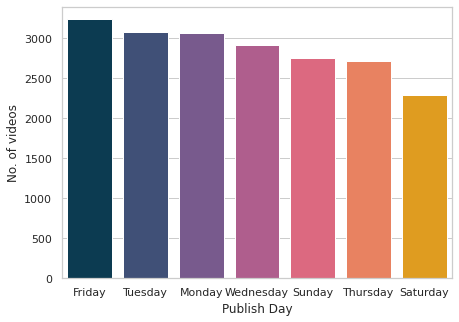

In [ ]:
cdf = df["publish_day"].value_counts()\
    .to_frame().reset_index().rename(columns={"index": "publish_day", "publish_day":
"No_of_videos"}) 
fig, ax = plt.subplots(figsize=(7,5)) 
_ = sns.barplot(x="publish_day", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#003f5c', '#374c80', '#7a5195', '#bc5090', '#ef5675', '#ff764a', '#ffa600'], n_colors=7), ax=ax) 
_ = ax.set(xlabel="Publish Day", ylabel="No. of videos")

We can see that the number of trending videos published on Sunday are noticeably less than the number of trending videos published on other days of the week. Highest number of trending videos have been published on Friday.

Next, lets see what hour of the day are the most trending videos been published.

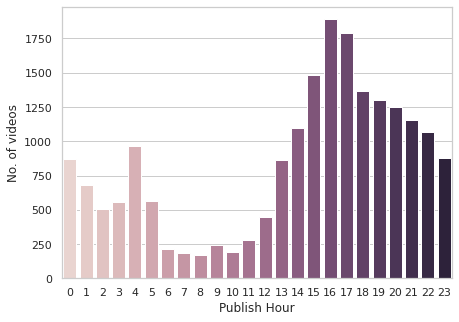

In [ ]:
cdf = df["publish_hour"].value_counts().to_frame().reset_index()\
    .rename(columns={"index": "publish_hour", "publish_hour": "No_of_videos"}) 
fig, ax = plt.subplots(figsize=(7,5)) 
_ = sns.barplot(x="publish_hour", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(n_colors=24), ax=ax) 
_ = ax.set(xlabel="Publish Hour", ylabel="No. of videos")

We can see that the most trending videos have been published in the later half of the day from 2pm to 11pm. 

###Trending categories and channels

Next we will find out:<br>
Which categories are people most interested in? What are the most popular channels?

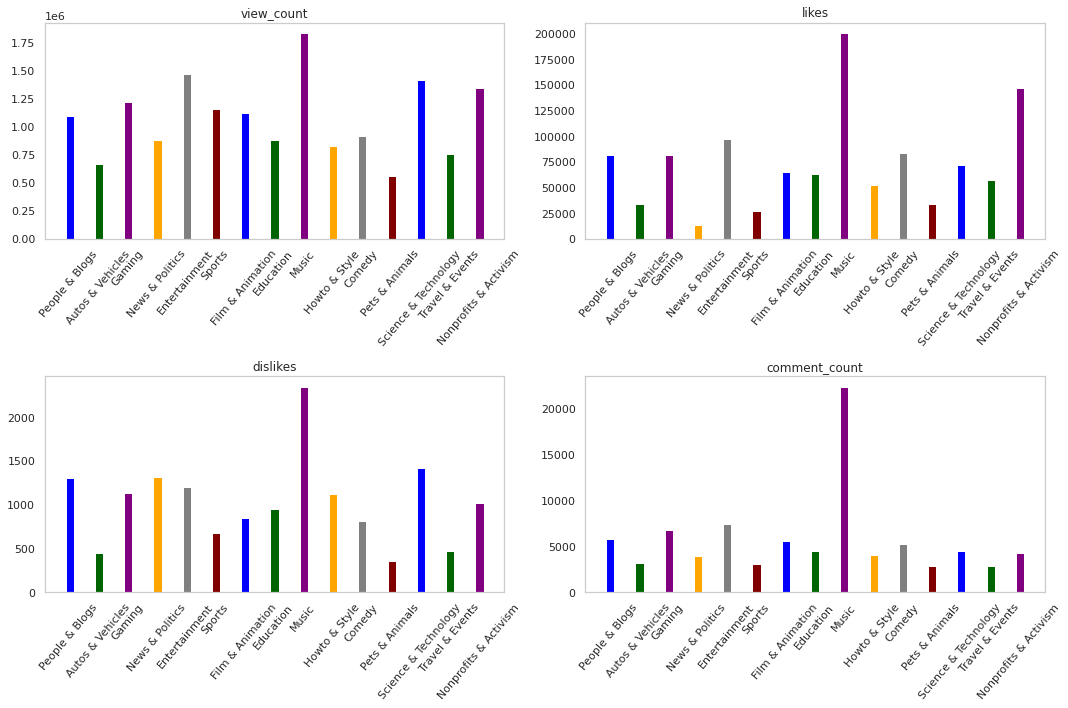

In [ ]:
to_int = ['view_count', 'likes', 'dislikes', 'comment_count']
for column in to_int:
    df[column] = df[column].astype(int)
    
measures = list()
n_groups = len(category_list)
for i, typ in enumerate(to_int):
    measure = list()
    for c in category_list:
        measure.append(df[df['category']==c][typ].agg('sum')/len(df[df['category']==c].index.unique()))
    measures.append(measure)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.07


for i, axs in enumerate([[ax1, ax2], [ax3, ax4]]):
    for j, ax in enumerate(axs):
        ax.bar(index + (bar_width), measures[(i+j)+i], bar_width*4,color=['blue','darkgreen','purple','orange','gray','Maroon'])
        fig.tight_layout()
        ax.set_title(to_int[(i+j)+i])
        ax.set_xticks(index + bar_width / 2)
        ax.grid(False)
        ax.set_xticklabels(category_list, rotation = 50)

Based on the observation, we see that the music is the dominant category for most popular video. It indicates that user are more likely to listen to video related to popular artist. The least popular video we see are towards news and politics in youtube videos.

Let's look at the distribution of videos per category in our dataset.

category
Autos & Vehicles          377
Comedy                   1079
Education                 455
Entertainment            3913
Film & Animation          753
Gaming                   3665
Howto & Style             605
Music                    3345
News & Politics           788
Nonprofits & Activism      17
People & Blogs           1737
Pets & Animals             93
Science & Technology      679
Sports                   2435
Travel & Events            91
Name: c_title, dtype: int64

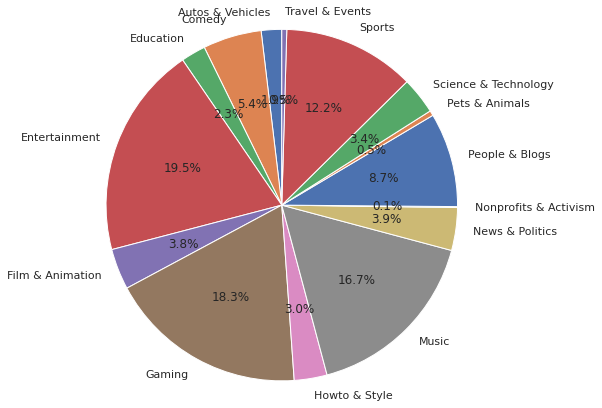

In [ ]:
labels = df.groupby(['category']).count().index
sizes = df.groupby(['category']).count()['c_title']
explode = (0, 0, 0, 0.1, 0)  

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sizes

The popularity of a channel on which the trending videos are posted also makes an important feature to explore. Let us look at the top 10 youtube channels in USA.

In [ ]:
df['publish_year'] = df['publish_date'].dt.year
grouped = pd.pivot_table(df,index='channelTitle',columns=['publish_year'],values='index',aggfunc='count',margins='sum')
grouped = grouped.sort_values(by='All', ascending=False).head(11)
grouped = grouped.sort_values(by='All', ascending=True)
grouped = grouped.drop(['All'])
grouped.drop(['All'], axis=1, inplace=True)

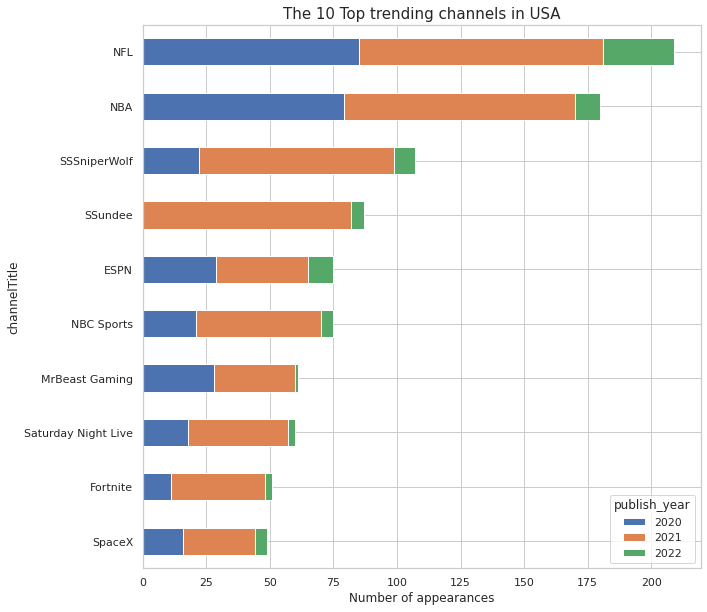

In [ ]:
grouped.plot.barh(stacked=True,figsize=(10,10))
plt.title('The 10 Top trending channels in USA',fontsize=15)
plt.xlabel('Number of appearances')
plt.show()

Result: NFL is the the top channel of USA in all the three years of data in our dataset.

### Trending videos

After exploring which categories, channels, year, date, time have most trending videos, let us move our focus on details of trending videos now. Which videos are the most trending with respect to features like view_count, likes, comment_count ? What are the characteristics of the most trending videos the these feature space?  

We look at the top 10 videos and each of the user features to identity similar and correlation between user features.

In [ ]:
def tableview_topvideos(title,column):
    df_table = df.groupby(title)[['view_count', 'likes','comment_count','dislikes']].apply(lambda x: x.sum())
    return df_table.sort_values(by=column, ascending=False)[:10]

In [ ]:
tableview_topvideos('c_title','view_count')

,view_count,likes,comment_count,dislikes
c_title,,,,
LISA - 'LALISA' M/V,85890366,5921316,1958529,38624
Cardi B - WAP feat. Megan Thee Stallion [Official Music Video],76805026,2820345,270263,382578
BTS 'Butter' Official MV,67111752,7110071,3400291,8998
MvRyhan Funny videos #tiktok #Shorts,59410897,1176893,4850,39704
BTS 'Dynamite' Official MV,57229275,7045907,2314087,165420
BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,51234434,5912778,1847794,405329
Oddly Satisfying Video #Shorts,50740092,1671219,4143,56972
My hidden talent #shorts,49423130,1592335,3163,27861
- Official MV,49042379,1669614,301291,8861


In [ ]:
def visualize_topvideos(title, columns):
  for column in columns:
    most_viewed_df = df.groupby([title])[column].sum().reset_index()
    sorted_df= most_viewed_df.sort_values(column, ascending=False)[:10]
    plt.figure(figsize=(10,5))
    # customizes the video titles, for asthetic purposes for the bar chart
    labels = []
    for item in sorted_df[title]:
        labels.append(item[:20])
    sns.barplot(x = labels, y = column, data = sorted_df)
    plt.xticks(rotation = 65, fontsize=12)
    plt.title("Top 10 Videos Based on " + column)
    plt.xlabel(title, fontsize=12, labelpad=25)
    plt.ylabel(column, fontsize=12, labelpad=25)
    plt.grid(False)
    plt.show()

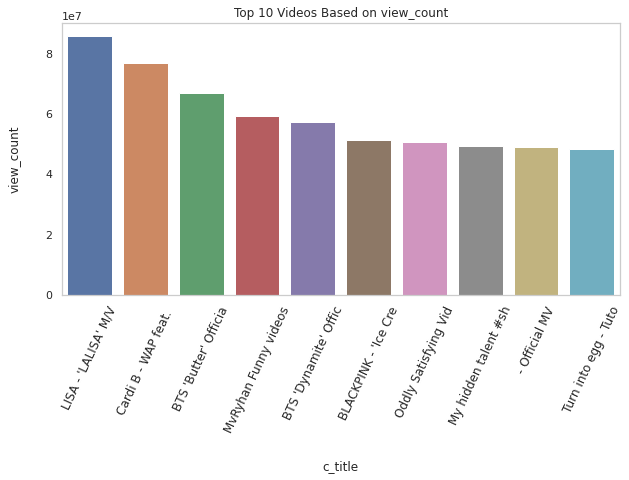

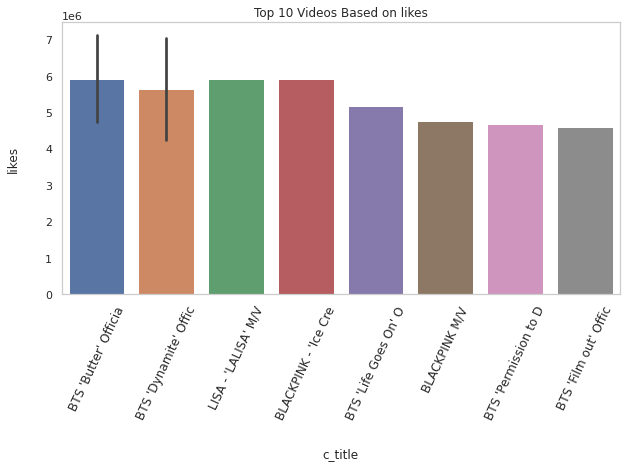

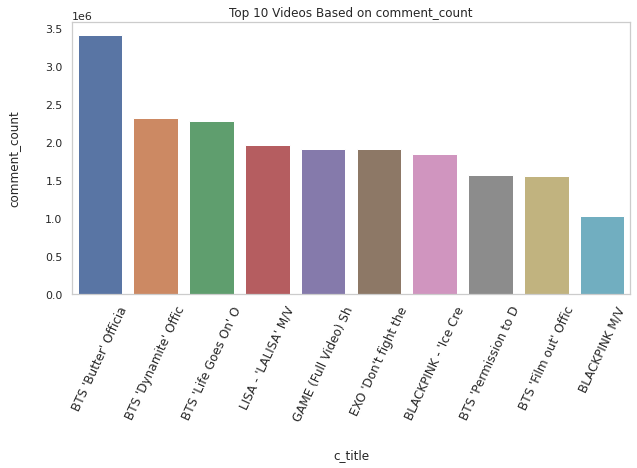

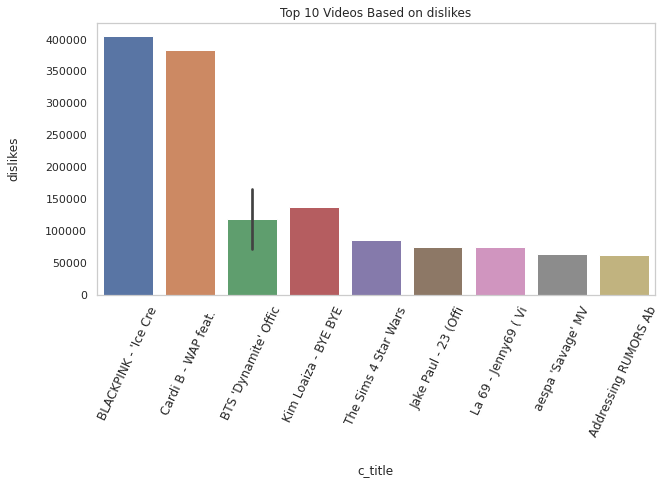

In [ ]:
visualize_topvideos('c_title' , ['view_count', 'likes','comment_count','dislikes'])

We can see top 10 trending video with the various factors. The title of the top trending is BTS butler which is same for likes and comments and We have LaLisa for views as indicator for the most trending video. But most of the videos are the same for likes, views and comments. So the trending video is the combination with other factors.  If you look at the top 10 dislike videos, you see that BTS bulter is not top dislike indicating it has more likes than dislike as BTS bulter is more likeable by the audience. 

<b>Ratio of Like and dislike in different Categories 

We see that top 10 videos had more likes than dislikes but there might be some that might be similar in ratio. So we check to see the ratio of like and dislike and in which category is it more trending.

So we see that the higher the ratio, the more the content of the youtube video was liked by the users as seen below.

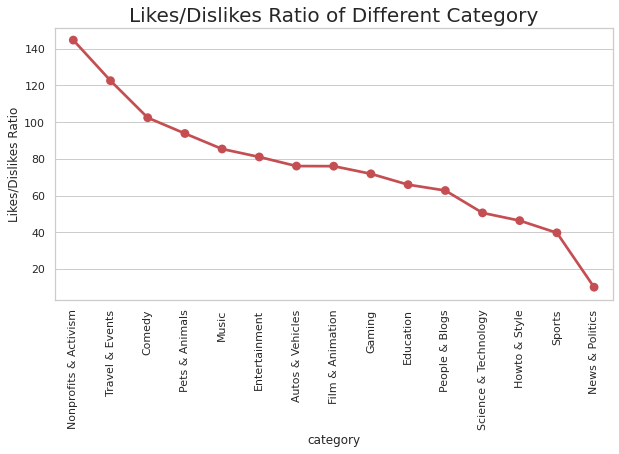

In [ ]:
likesdislike_df = df.groupby('category')[['likes', 'dislikes']].sum().reset_index()
likesdislike_df['Likes/Dislikes Ratio'] = likesdislike_df['likes'] / likesdislike_df['dislikes']
likesdislike_df = likesdislike_df.sort_values(by='Likes/Dislikes Ratio', ascending=False).reset_index()
fig1 = plt.subplots(figsize=(10,5))

sns.pointplot(x="category", y="Likes/Dislikes Ratio", data=likesdislike_df, color="r")
plt.xticks(rotation=90)
plt.title("Likes/Dislikes Ratio of Different Category", fontsize=20)
plt.show()

Based on the result of the plot we see that there are higher ratio of likes over dislike in the categories of Travels and Event and least in the News and Politics videos. It tells us that our audience that viewed the content are more interested in events and entertainments compare to watching news. 

<b>Top 5 Videos that stayed trending for maximum number of days

In [ ]:
us_videos_trending_days = df.groupby('c_title')['trending_date'].unique().to_frame()
us_videos_trending_days['days'] = us_videos_trending_days.trending_date.transform(lambda x: len(x))
us_videos_trending_days = us_videos_trending_days.sort_values(by='days', ascending=False).reset_index()[:5]
us_videos_trending_days

,c_title,trending_date,days
0,Starlink Mission,"[2020-08-19T00:00:00.000000000, 2020-09-05T00:...",24
1,Most Oddly Satisfying Video to watch before sleep,"[2020-10-19T00:00:00.000000000, 2021-03-09T00:...",9
2,,"[2020-10-21T00:00:00.000000000, 2020-11-23T00:...",7
3,Creative People On Another Level,"[2020-10-08T00:00:00.000000000, 2020-10-27T00:...",6
4,Apex Legends | Stories from the Outlands,"[2020-08-12T00:00:00.000000000, 2020-10-27T00:...",5


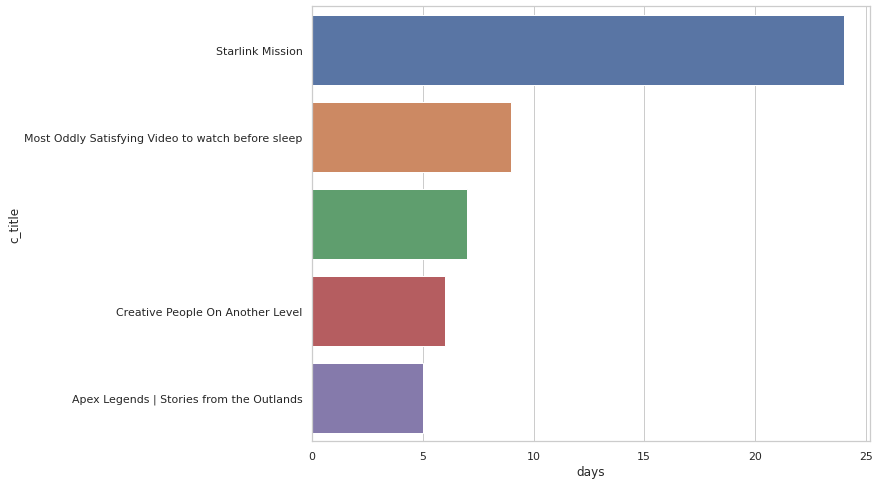

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x = "days", y = "c_title", data = us_videos_trending_days)
plt.show()

<b> Top 10 Most frequent type of video in trending within the 2 weeks

In [ ]:
from datetime import datetime,date, timedelta
today=date.today()
two_weeks_ago=date.today() - timedelta(days=14)
print("Two week ago date: ",two_weeks_ago)
week_ago_condition=(df['trending_date'].dt.date>=two_weeks_ago) & (df['trending_date'].dt.date<=today)
us_trending_videos_week_ago=df[week_ago_condition]

Two week ago date:  2022-02-25


In [ ]:
most_frequent_type=us_trending_videos_week_ago.groupby(['category']).count().loc[:,:][:10]
most_frequent_type=most_frequent_type.reset_index()
most_frequent_type=most_frequent_type.rename(columns={'video_id': 'count'})

for idx,most_freq_category in enumerate(most_frequent_type['category']):
    for category in df['category']:
        if str(most_freq_category)==category:
            most_frequent_type.at[idx,'category']=category
            break

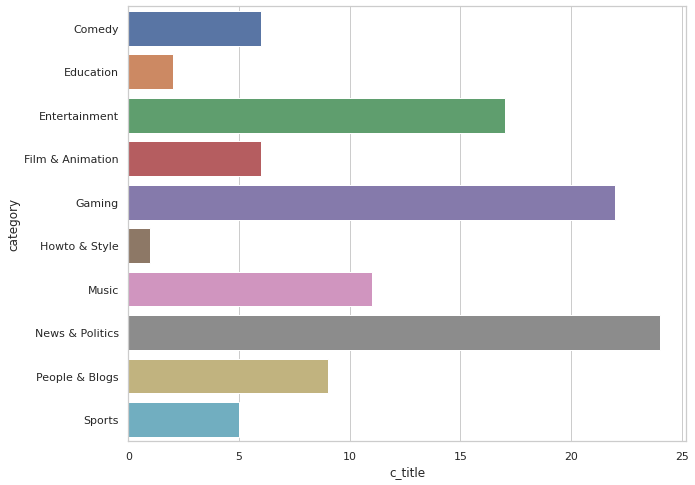

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x = "c_title",y = "category", data = most_frequent_type)
plt.show()

Does CAPITAL Title affect visibility in youtube trends

In [ ]:
def caps_percent(title):
    title = title.replace(" ","")
    if len(title) <= 0: return 0 
    s = 0
    for cr in title:
        if cr.isupper():
            s += 1
    return ((round((s/len(title))*100,0)) // 5)*5
    #To make categories based on 5

df['percent_caps'] = df.c_title.apply(caps_percent)
df['len_title'] = df.c_title.apply(len)

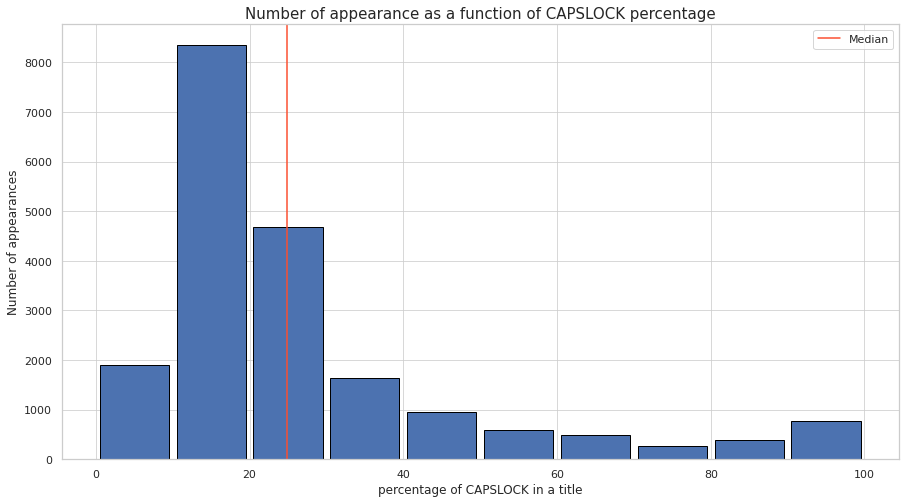

In [ ]:
plt.figure(figsize=[15,8])
plt.hist(df['percent_caps'],edgecolor='black', rwidth=0.9)

median_caps = df['percent_caps'].mean()
plt.axvline(median_caps,color='#fc4f30',label='Median')

plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.title('Number of appearance as a function of CAPSLOCK percentage',fontsize=15)
plt.xlabel('percentage of CAPSLOCK in a title')
plt.ylabel('Number of appearances')

plt.show()

Does ViewCount of a video affect youtube trends?

In [ ]:
def views_cat(views):
    if views <= 10000: return 'less than 10k'
    if views <= 25000: return '25k'
    if views <= 50000: return '50k'
    if views <= 75000: return '75k'
    if views <= 100000: return '100k'
    if views <= 250000: return '250k'
    if views <= 500000: return '500k'
    if views <= 750000: return '750k'
    if views <= 1000000: return '1m'
    if views <= 2500000: return '2.5m'
    if views <= 5000000: return '5m'
    if views <= 7500000: return '7.5m'
    if views <= 10000000: return '10m'
    if views <= 15000000: return '15m'
    else: return 'more than 15m'
            

df['views_cat'] = df.view_count.apply(views_cat)

In [ ]:
#Pivot table to create views category based on views_cat colum
appreanf_f_view = df.groupby('views_cat').size().reset_index(name='counts').sort_values(by='counts', ascending=True)
sorter = ['less than 10k','25k','50k','75k','100k','250k','500k','750k','1m','2.5m','5m','7.5m','10m','15m','more than 15m']
sorterIndex = dict(zip(sorter, range(len(sorter))))
appreanf_f_view['rank'] = appreanf_f_view['views_cat'].map(sorterIndex)
appreanf_f_view = appreanf_f_view.sort_values(by='rank')
appreanf_f_view.drop(['rank'], axis=1, inplace=True)

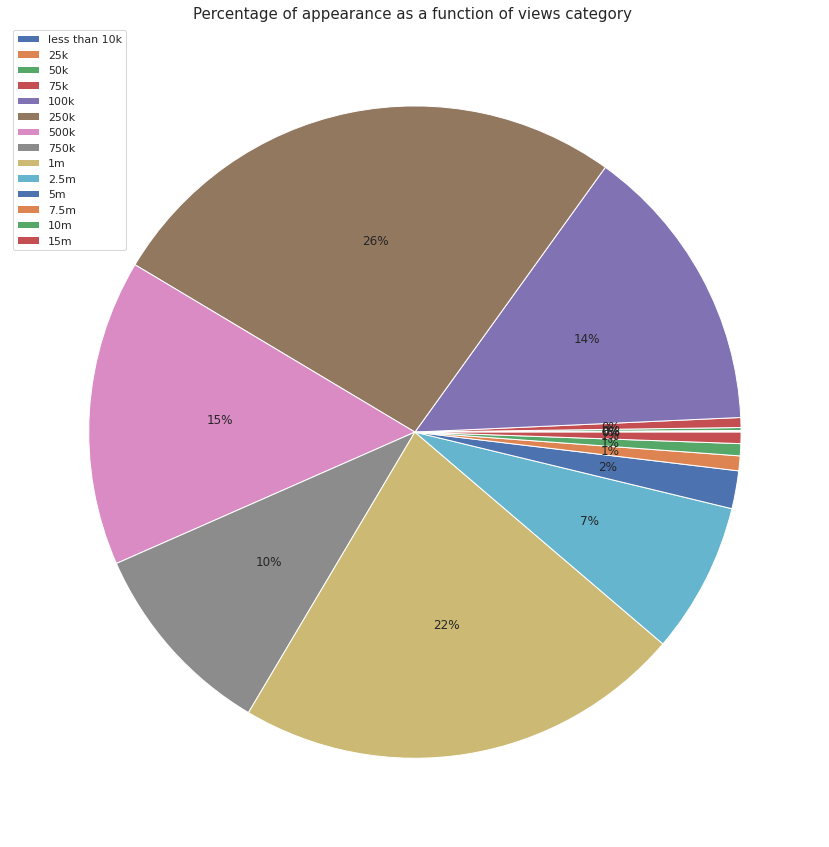

In [ ]:
plt.figure(figsize=[25,15])
plt.pie(appreanf_f_view.counts,autopct='%1.0f%%')


plt.legend(sorter)
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.title('Percentage of appearance as a function of views category ',fontsize=15)

plt.show()

**Analysis**





As we can see, two categories outperform the others:


*   Between 250k and 500k views
*   Between 500k and 1M views



However, it is interesting that all the categories are dispatched almost equally. It seems that the YouTube algorithm is not giving any huge advantage for videos depending on their number of views.

What is also interesting is that we can find videos with less than 50k views on the trending page, offering tremendous visibility for these channels.


In [ ]:
def getDaytime(x):
    if x.hour>4 and x.hour<=10:
        return "Morning"
    elif x.hour>10 and x.hour<=16:
        return "Afternoon"
    elif x.hour>16 and x.hour<=22:
        return "Evening"
    else:
        return "Night"

df["daytime"]=df.publish_time.apply(lambda x: getDaytime(x))
df.head()

,index,publish_date,publish_time,category,channelId,channelTitle,trending_date,view_count,likes,dislikes,...,description,c_title,c_tags,publish_day,publish_hour,publish_year,percent_caps,len_title,views_cat,daytime
video_id,,,,,,,,,,,,,,,,,,,,,
3C66w5Z0ixs,0,2020-08-11,19:20:14,People & Blogs,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,2020-08-12,1514614,156908,5855,...,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,I ASKED HER TO BE MY GIRLFRIEND...,brawadis|prank|basketball|skits|ghost|funny vi...,Tuesday,19,2020,85.0,34,2.5m,Evening
6f-jjV5LJoE,127,2020-08-09,15:00:01,Autos & Vehicles,UCNSMdQtn1SuFzCZjfK2C7dQ,FortNine,2020-08-12,342870,30254,580,...,As the generation that grew up playing Road Ra...,Road Rage Why Motorcycle Riders Smash Windows,motorcycle road rage compilation|motorcycle cr...,Sunday,15,2020,15.0,45,500k,Afternoon
QsUfsZzxi9c,128,2020-08-06,17:00:23,Gaming,UCIPPMRA040LQr5QPyJEbmXA,MrBeast Gaming,2020-08-12,13073796,1643982,16286,...,We have a giant area of land and whatever you ...,"Whatever You Build, I'll Pay For!",[None],Thursday,17,2020,20.0,33,15m,Evening
THQH9QJKrIE,129,2020-08-08,21:15:00,News & Politics,UCHd62-u_v4DvJ8TCFtpi4GA,Washington Post,2020-08-12,523172,6045,1076,...,After negotiations with Democrats in Congress ...,"Trump signs executive orders on unemployment, ...",debt|student loans|unemployment aid|cares act|...,Saturday,21,2020,0.0,86,750k,Evening
xCkpA4_H1x4,130,2020-08-08,14:30:05,Gaming,UC_F8DoJf9MZogEOU51TpTbQ,Clash Royale,2020-08-12,2635254,73921,2694,...,Clan Wars 2 is coming. Get ahead of the compet...,UPDATE: CLAN WARS 2 How does it work? TV Royal...,Clash Royale|Clash Royale Game|Supercell|Super...,Saturday,14,2020,35.0,67,5m,Afternoon


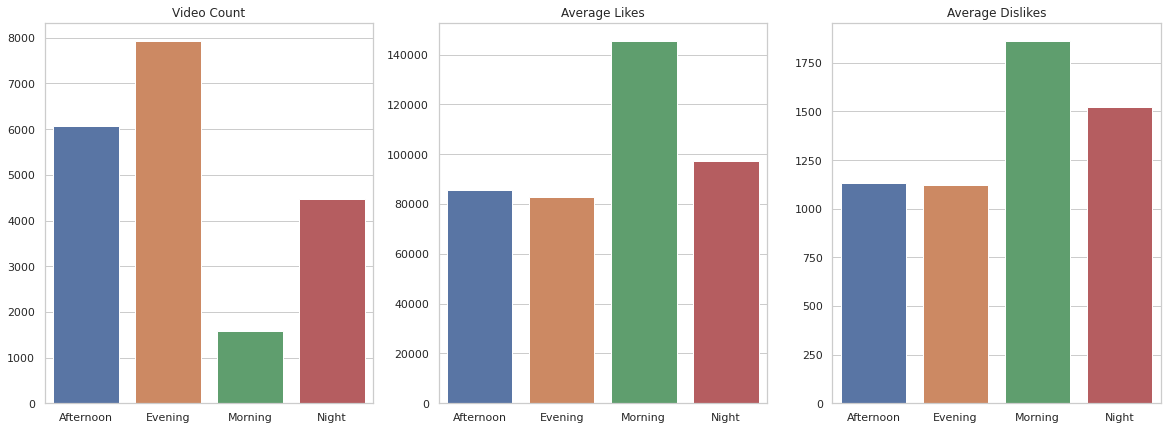

In [ ]:
#Checking Video counts and Avg likes by plotting them
youtube_df_grouped = df.groupby('daytime').agg({'daytime':'count','likes':'mean','dislikes':'mean'})
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title ("Video Count")
g1=sns.barplot(x=youtube_df_grouped.index, y= 'daytime', data=youtube_df_grouped)
g1.set(xlabel=None, ylabel=None)
plt.subplot(1,3,2)
plt.title ("Average Likes")
g2=sns.barplot(x=youtube_df_grouped.index, y= 'likes', data=youtube_df_grouped)
g2.set(xlabel=None, ylabel=None)
plt.subplot(1,3,3)
plt.title ("Average Dislikes")
g3=sns.barplot(x=youtube_df_grouped.index, y= 'dislikes', data=youtube_df_grouped)
g3.set(xlabel=None, ylabel=None)
plt.show()

## **Natural Language Processing (Sentimental Analysis):**

Natural Language Processing (NLP) is a data science operation that relies heavily on Bayesian probability techniques. Using probability-based Naive Bayes Classifer algorithms (which naively assume conditional independence of all features) we use our code to detect sentiment and count the words associated with those feelings. We can then also use probability calculations (for example, P[positive|liked the video] to classify comments. We can also perform feature engineering using word frequencies. Careful feature engineering will enhance the usefulness of our NLP analysis.

In [ ]:
import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
top_N = 100
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def stopwordsremoval(title):
  #convert list to text
  a = df[title].str.lower().str.cat(sep=' ')
  # removes punctuation,numbers and returns list of words
  b = re.sub('[^A-Za-z]+', ' ', a)
  tokens = word_tokenize(b)
  non_stopwords_sentence = []
  for word in tokens:
      if word not in stopwords:
          non_stopwords_sentence.append(word) 
  return non_stopwords_sentence     


Visualization for Frequency of words used in Title Variable:

In [ ]:
clean_sentences = stopwordsremoval('c_title')
without_single_chr = []
for word in clean_sentences:
  if len(word) > 2:
    without_single_chr.append(word)

# Remove numbers in the words 
data_title = [word for word in without_single_chr if not word.isnumeric()]        

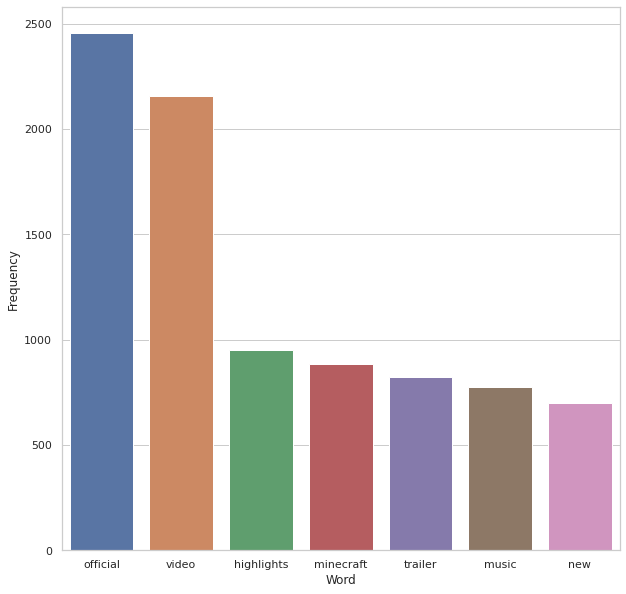

In [ ]:
# Calculate frequency distribution
word_dist = nltk.FreqDist(data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

Result:
The term "Official" is used the most frequently, as shown in the graph above.



Categorizing the Title column into Positive and Negative sentiments using TextBlob


We have used sentiment analysis to find the nature of titles i.e. to find the polarity of the words in the title. Here we have used 'Title' variable for plotting.

In [ ]:
from textblob import TextBlob

bloblist_title = list()

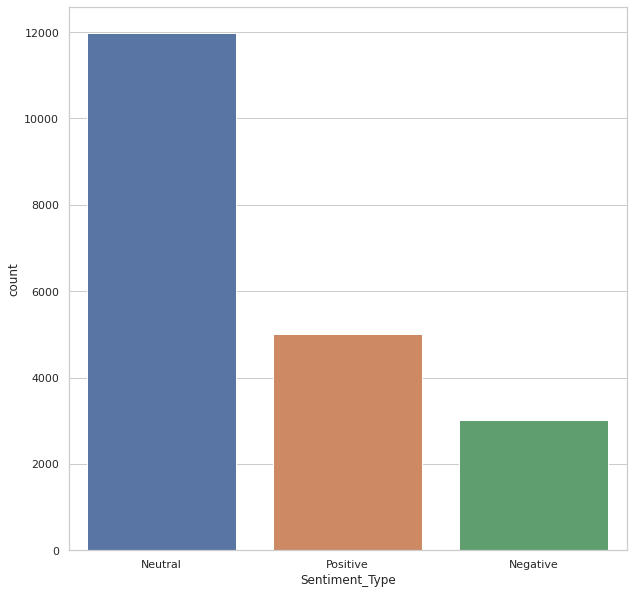

In [ ]:
df_usa_title_str=df['c_title']
for row in df_usa_title_str:
    blob = TextBlob(row)
    bloblist_title.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_usa_polarity_title = pd.DataFrame(bloblist_title, columns = ['sentence','sentiment','polarity'])
 
def f_title(df_usa_polarity_title):
    if df_usa_polarity_title['sentiment'] > 0:
        val = "Positive"
    elif df_usa_polarity_title['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_usa_polarity_title['Sentiment_Type'] = df_usa_polarity_title.apply(f_title, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_usa_polarity_title)

We looked into how the length of a video's title relates to the amount of views it obtains. We investigated if the length of a video's title affects the amount of views it receives.
Result: The majority of video titles are neutral, followed by positive and negative.



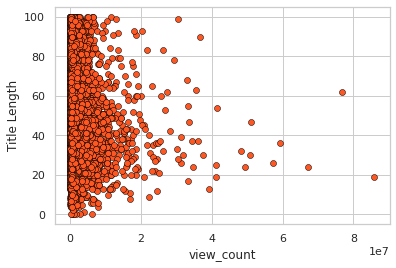

In [ ]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
df["title_length"] = df["c_title"].apply(lambda x: len(x))
fig,ax= plt.subplots()
_ = ax.scatter(x=df['view_count'], y=df['title_length'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5) 
_ = ax.set(xlabel="view_count", ylabel="Title Length")

Result:
The picture shows that if the title is too long or too short, the number of views is lower than for a video title with a moderate amount of words. The range for moderate words is 40-50 words in this case.

In [ ]:
def worddcloud(column):
  words =[]
  tags_words = [w.split()for w in df[column]]
  for tag_word in tags_words:
    for x in tag_word:
      words.append(x)
  Counter(words).most_common(25)
  wc = wordcloud.WordCloud(width=1200, height=535, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))
  plt.figure(figsize=(15,10))
  plt.imshow(wc, interpolation='bilinear')
  _ = plt.axis("off")

Visualization for Frequency of words used in Tags Column:

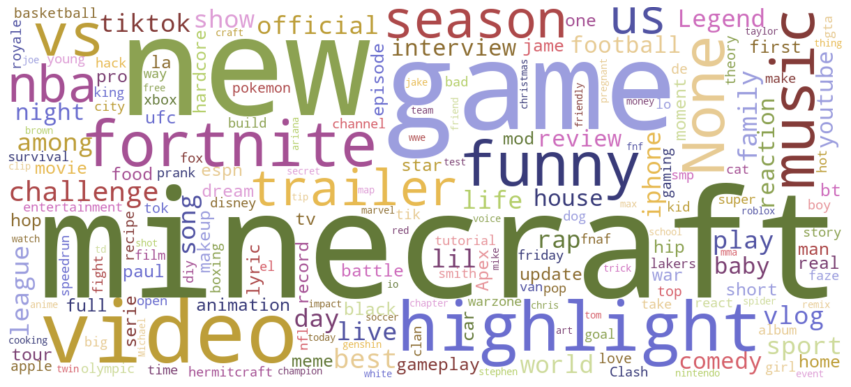

In [ ]:
worddcloud("c_tags")

Visualization for Frequency of words used in Description Column:

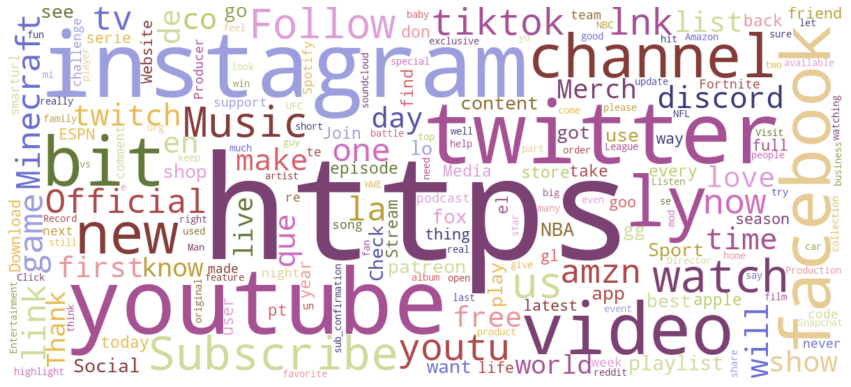

In [ ]:
worddcloud("description")

##Machine Learning 

GOAL: To construct a Machine learning model to predict how many more days a video will trend given views,likes,dislikes,comment_count, published date and trending date

For each video_id and trending_date extract the maximun view_count,Likes,Dislikes,Comment_count

In [ ]:
df1 = pd.read_csv('US_youtube_trending_data.csv')
df1.reset_index(inplace = True)
df1.fillna(value = '', inplace = True)
ML_df= df1.groupby(['video_id','trending_date','publishedAt'],as_index=False).agg({'view_count':\
                                                             'max','likes':'max','dislikes':'max','comment_count':'max'})

In [ ]:
df1 = ML_df.copy()

In [ ]:
df1['trending_date'] = pd.to_datetime(df1['trending_date'])
df1['publishedAt'] = pd.to_datetime(df1['publishedAt'])

Each video trends for multiple days so we are creating a new feature 'trending_day_no' which will give us the current trending day number for each record¶
We are adding this feature to retain the metrics like likes, dislikes, view, comment_count for each trending day number
To use it for predicting how many more days a video can trend

In [ ]:
df.keys()

Index(['index', 'publish_date', 'publish_time', 'category', 'channelId',
       'channelTitle', 'trending_date', 'view_count', 'likes', 'dislikes',
       'comment_count', 'comments_disabled', 'ratings_disabled', 'description',
       'c_title', 'c_tags', 'publish_day', 'publish_hour', 'publish_year',
       'percent_caps', 'len_title', 'views_cat', 'daytime', 'title_length'],
      dtype='object')

Because each video has many days of trending, we're introducing a new feature called 'trending day no,' which will provide us with the current trending day number for each record.
This functionality is being added to keep track of data such as likes, dislikes, views, and comment count for each trending day number.
It may be used to forecast how many days a video will continue to trend.

In [ ]:
df1['trending_day_no'] = df1.groupby(['video_id'])["trending_date"].rank('first',ascending=True)

Calculating total trending days for each video

In [ ]:
df1_count = df1.groupby('video_id',as_index=False)["trending_date"].count().rename(columns={\
                                                                'trending_date':'total_trending_days'})

In [ ]:
df2 = df1.merge(df1_count, left_on='video_id', right_on='video_id')
df2.head()

,video_id,trending_date,publishedAt,view_count,likes,dislikes,comment_count,trending_day_no,total_trending_days
0,--14w5SOEUs,2021-06-11 00:00:00+00:00,2021-06-10 16:00:00+00:00,2146104,167034,1755,12998,1.0,5
1,--14w5SOEUs,2021-06-12 00:00:00+00:00,2021-06-10 16:00:00+00:00,3963014,218568,2847,15442,2.0,5
2,--14w5SOEUs,2021-06-13 00:00:00+00:00,2021-06-10 16:00:00+00:00,5167987,240113,3414,16241,3.0,5
3,--14w5SOEUs,2021-06-14 00:00:00+00:00,2021-06-10 16:00:00+00:00,6078723,252005,3778,16228,4.0,5
4,--14w5SOEUs,2021-06-15 00:00:00+00:00,2021-06-10 16:00:00+00:00,6823249,262692,4107,16445,5.0,5


In [ ]:
df2['published_year'] = df2.publishedAt.dt.year
df2['published_month'] = df2.publishedAt.dt.month
df2['published_day'] = df2.publishedAt.dt.day
df2['published_hour'] = df2.publishedAt.dt.hour
df2['published_minute'] = df2.publishedAt.dt.minute
df2['published_week'] = df2.publishedAt.dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
df2.drop(columns=['video_id', 'trending_date', 'publishedAt'],inplace=True) 

Now the dataset is ready for Machine learning

In [ ]:
X = df2.drop('total_trending_days',axis=1)
Y = df2.total_trending_days

In [ ]:
import sklearn.tree

In [ ]:
dt = sklearn.tree.DecisionTreeRegressor(max_depth = 2)

In [ ]:
dt.fit(X,Y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
Y.mean()

5.911006175081729

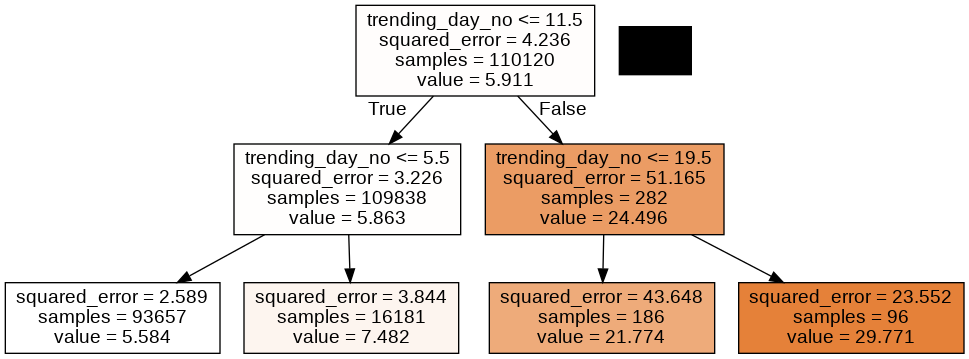

In [ ]:
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

We can deduce from the tree that if the trending days are fewer than 11.5, we can anticipate the overall number of trending days for a video with more accuracy, since videos typically trend for around 6 days. We notice a high MSE score on the right side of the tree because the data for videos that trend for more than 12 days is quite limited.

In [ ]:
trending_days_binned = pd.cut(Y, bins= [0,4,9,40])
trending_days_binned_count = trending_days_binned.value_counts().rename_axis('Binned_Trending_Days').reset_index(name = 'Count')

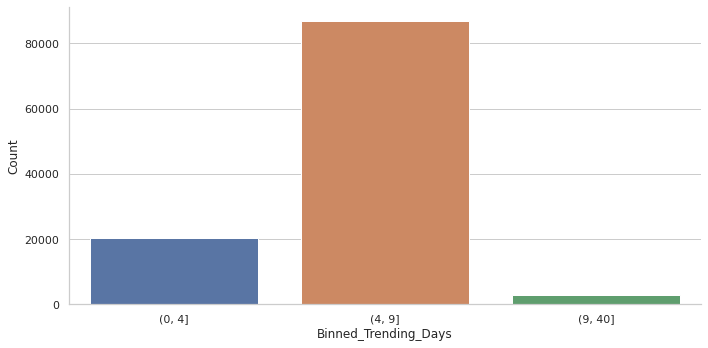

In [ ]:
sns.catplot( y='Count',x='Binned_Trending_Days',\
            data=trending_days_binned_count,kind='bar', aspect = 2)


Majority of the trending videos are trending for total 4 to 9 days so the decision tree regressor gives a better prediction for videos in that bin range

Video that does well on the trending page will be seen by more people, which will help the channel's reach grow. So, depending on the amount of views, likes, dislikes, and comments a video receives, channels may forecast the total number of days it will trend using this model.

In [ ]:
X = df2.drop('total_trending_days',axis=1)
Y = df2.total_trending_days

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                            test_size=0.3,random_state=0)

In [ ]:
from sklearn import linear_model

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train,Y_train)

LinearRegression()

In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
r2_score=sklearn.metrics.r2_score(Y_test, y_pred)

In [ ]:
print("Coefficient of determination: %.2f" % r2_score)

Coefficient of determination: 0.35


Mean Absolute Error and Mean Absolute deviation

In [ ]:
(y_pred-Y_test).abs().mean()

1.1569004134789707

In [ ]:
((y_pred-Y_test)**2).mean()

2.8658496896002297